# DSO 522: Applied Time Series Analysis for Forecasting

## Week 5: The forecaster’s toolbox (part 2)

### Fall 2024

#### Instructor: Dr. Matteo Sesia


<p align="center">
  <img src="img/marshall.png" alt="Marshall School of Business" width="600"/>
</p>

<link rel="stylesheet" type="text/css" href="custom.css">

# Interactive slides

These lecture slides are made using an interactive [Jupyter](https://jupyter.org/) notebook, powered by the [RISE](https://rise.readthedocs.io/en/latest/) extension.

In the lectures, we will run `R` code in Jupyter, using the `fpp3` package (which you should have already installed).

In [1]:
suppressMessages(library(fpp3))

library(repr)
options(repr.matrix.max.rows=4)
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 250)

## Forecasting with decomposition

Assuming an additive decomposition, the decomposed time series can be written as:
$$y_t = \hat{S}_t + \hat{A}_t,$$
where $\hat{A}_t = \hat{T}_t+\hat{R}_{t}$ is the seasonally adjusted component.

Or, if a multiplicative decomposition has been used, we can write
$$y_t = \hat{S}_t\hat{A}_t,$$
where $\hat{A}_t = \hat{T}_t\hat{R}_{t}$.

To forecast a decomposed time series, we forecast the seasonal component, $\hat{S}_t$, and the seasonally adjusted component $\hat{A}_t$, separately.

Usually:
 - A seasonal naïve method is used for the seasonal component (which should vary slowly).
 - To forecast the seasonally adjusted component, any non-seasonal forecasting method may be used. 

## Example: Production of Electricity in Australia from 2000 to mid-2010


During this period, Australia experienced significant changes in energy consumption patterns due to economic growth and technological advancements. 

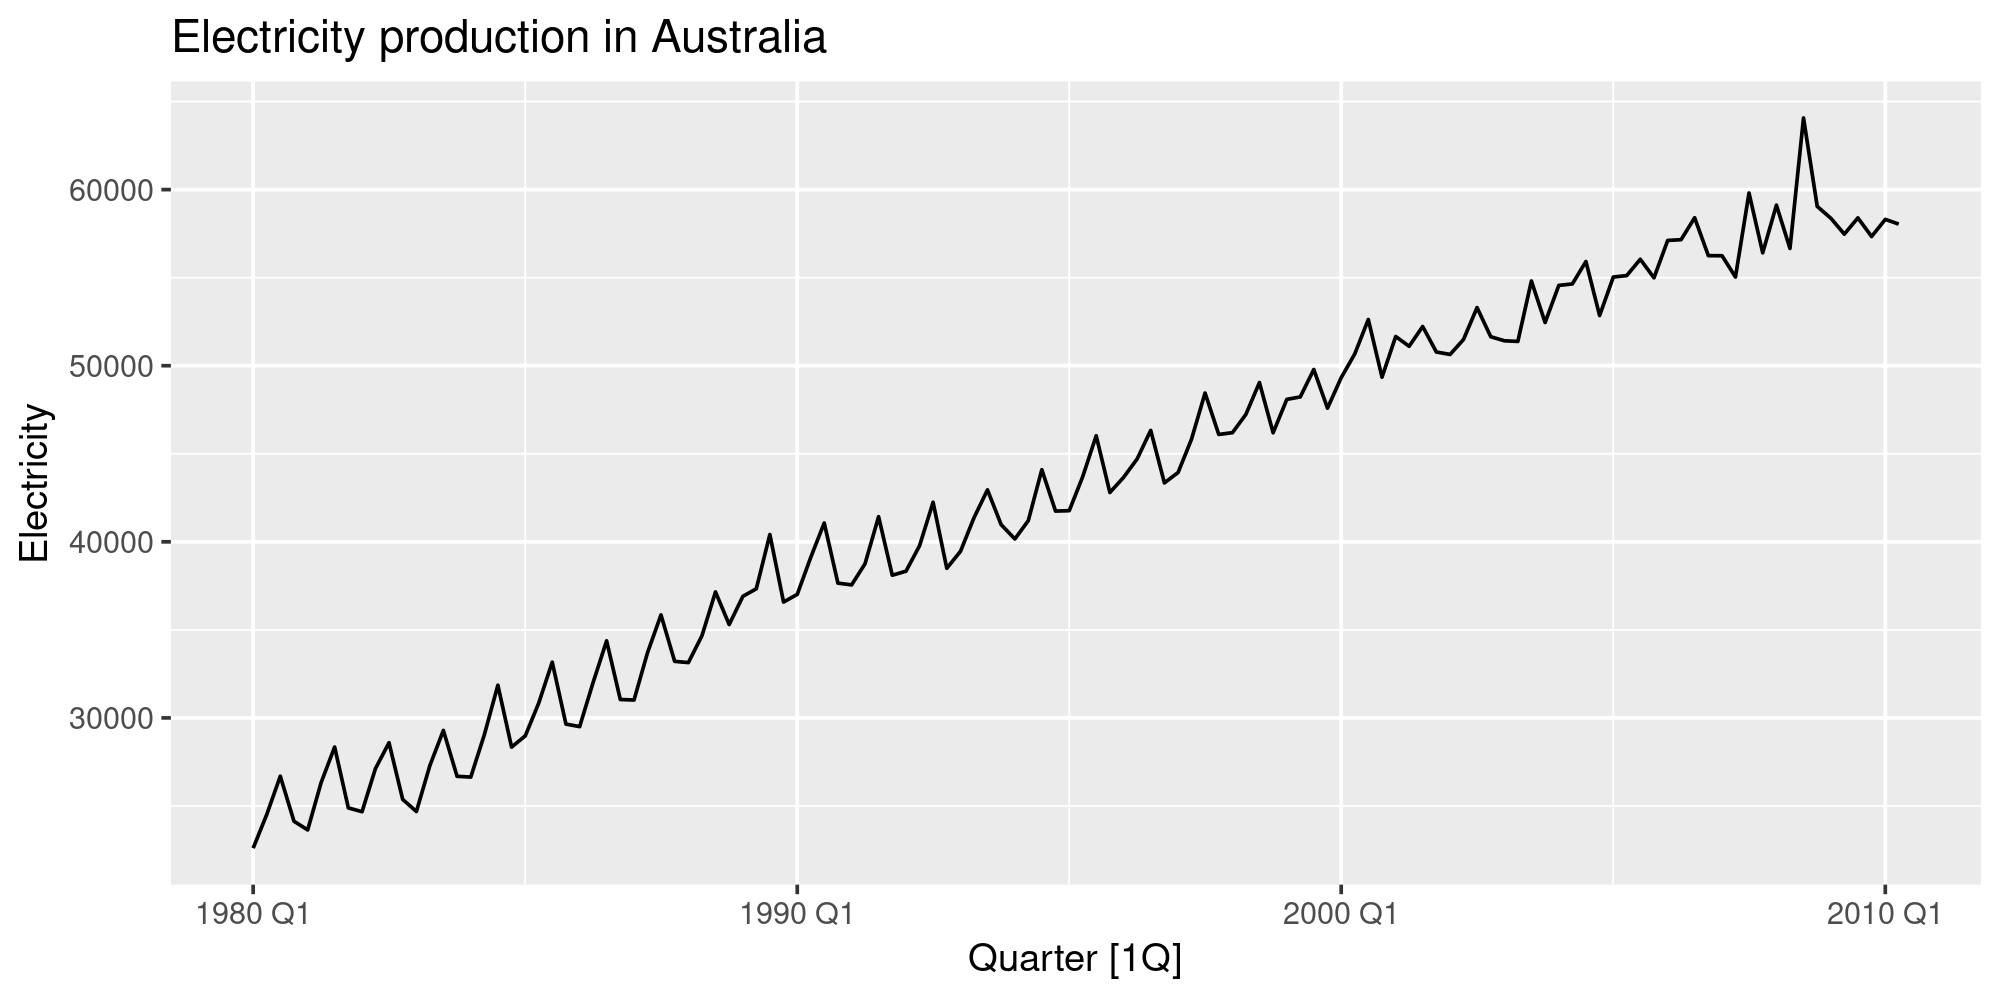

In [2]:
recent_aus_production <- aus_production |> filter(year(Quarter)>=1980)

recent_aus_production |>
    autoplot(Electricity) +
        labs(y = "Electricity", title = "Electricity production in Australia")

For businesses operating in this environment, recognizing and accurately forecasting these patterns meant the difference between profitability and loss. A mismatch between production and demand could lead to expensive energy shortages or surpluses that drive up costs. Understanding and modeling both the trend and seasonal components in the data is key to making informed, strategic decisions.

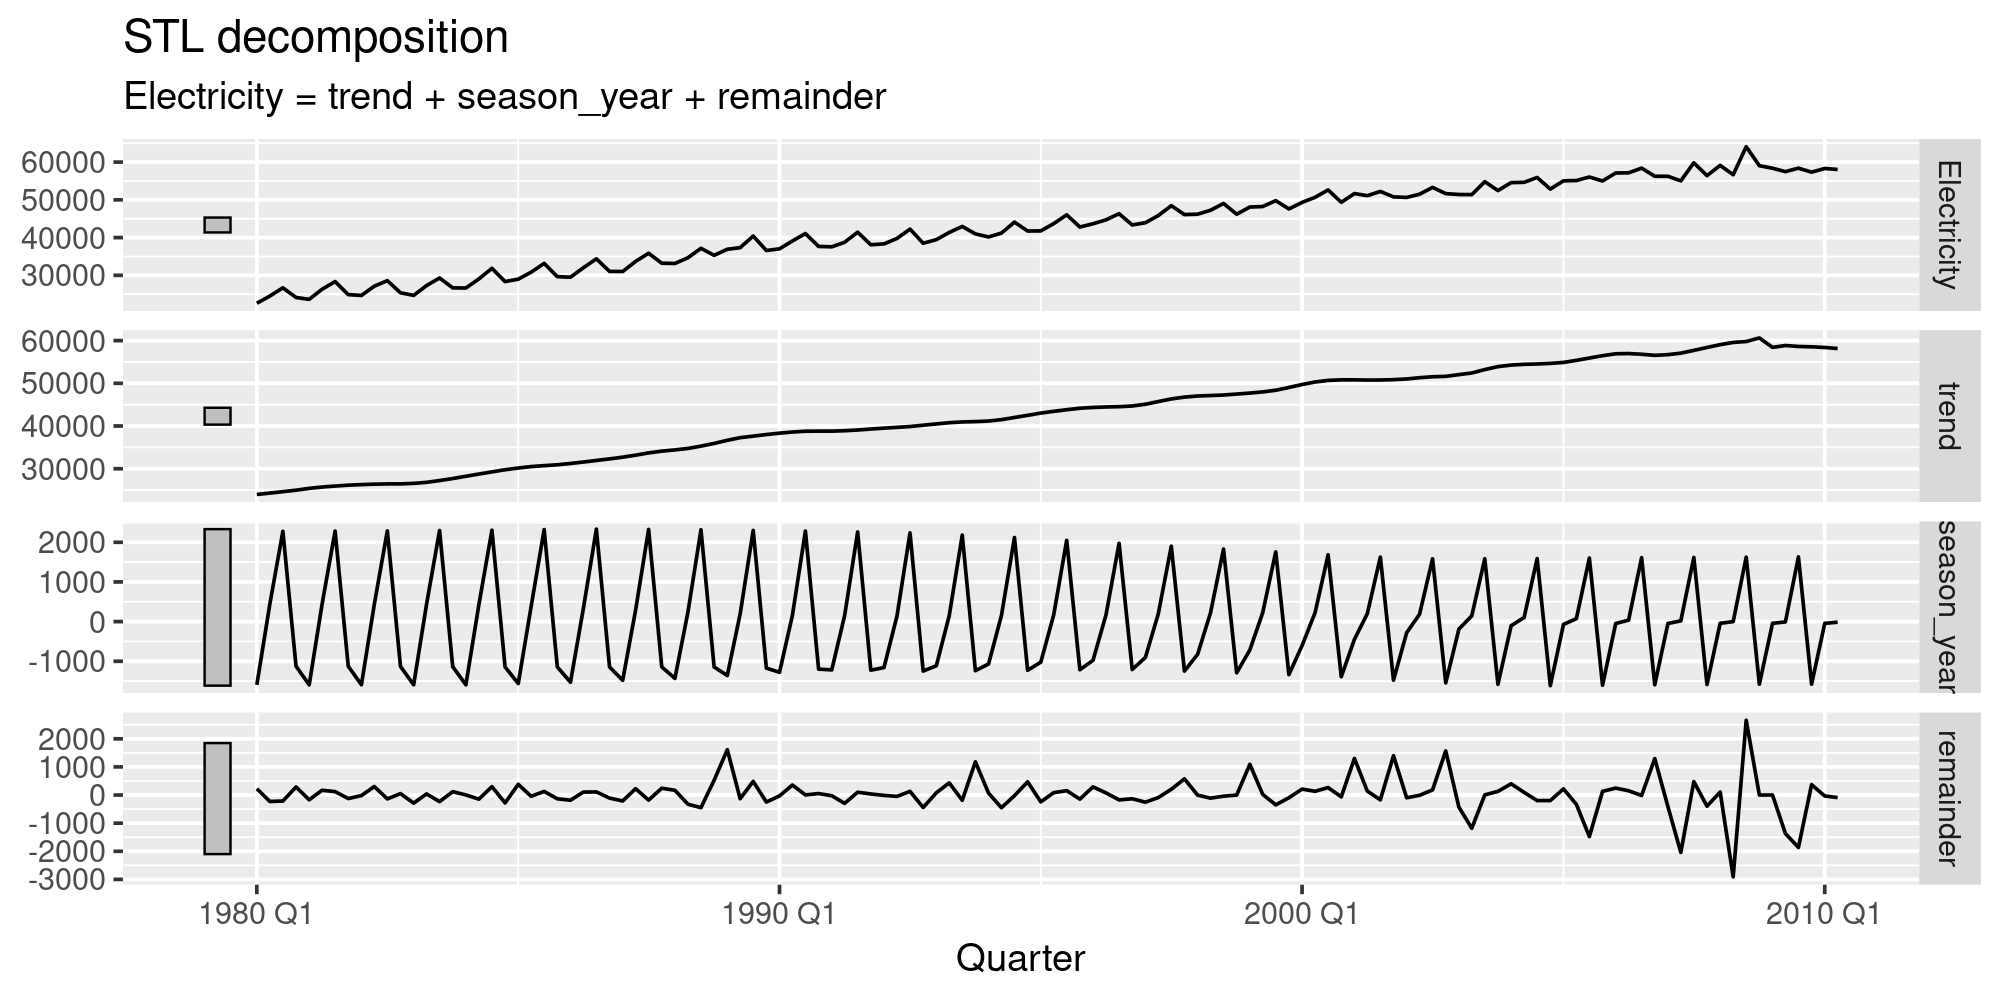

In [3]:
dcmp <- recent_aus_production |>
    model(STL(Electricity ~ trend(window = 7), robust = TRUE)) |>
    components()

dcmp |>
    autoplot()

dcmp <- dcmp |> select(-.model)

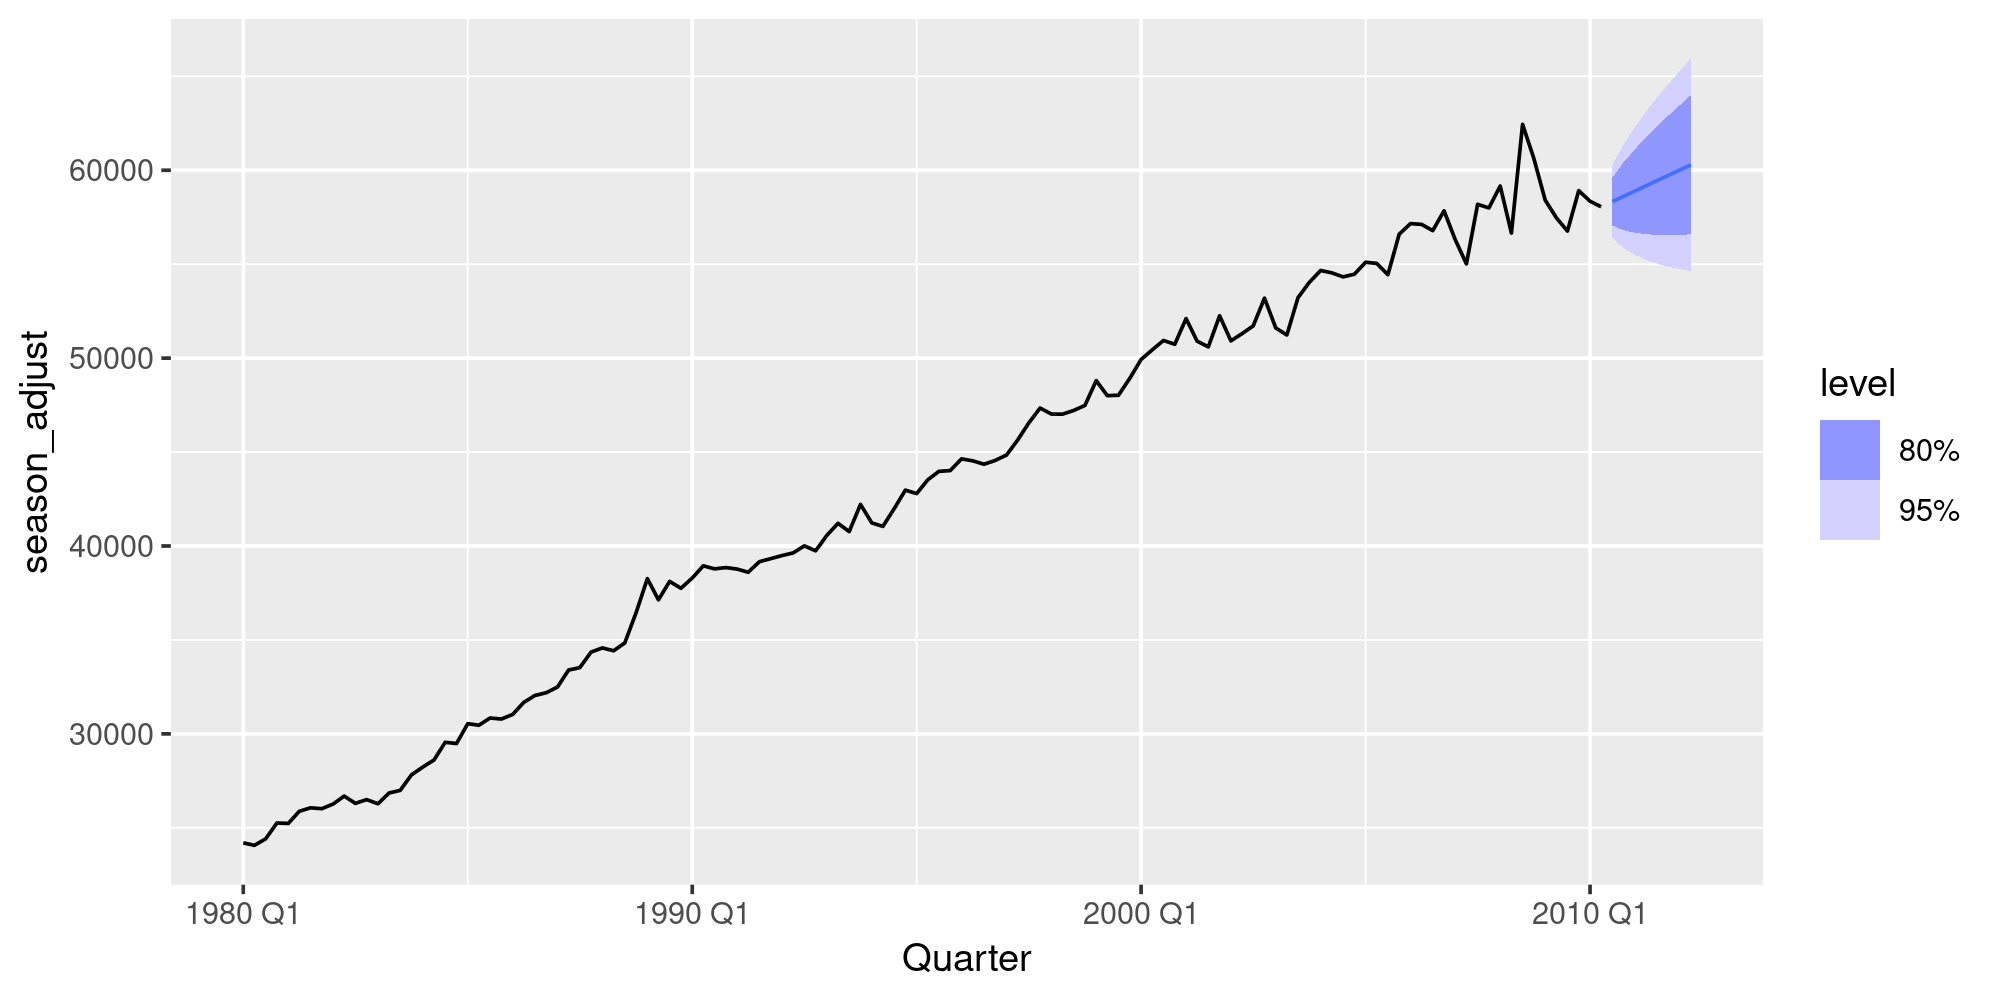

In [4]:
plot_seasonal_adjusted <- TRUE

if(plot_seasonal_adjusted) {
    dcmp |>
        model(NAIVE(season_adjust~drift())) |>
        forecast() |>
        autoplot(dcmp) 
} else {
    dcmp |>
        model(SNAIVE(season_year)) |>
        forecast() |>
        autoplot(dcmp)
}

The `decomposition_model()` function allows you to compute forecasts via any additive decomposition, using other model functions to forecast each of the decomposition’s components.

Seasonal components of the model will be forecast automatically using `SNAIVE()` if a different model isn’t specified.

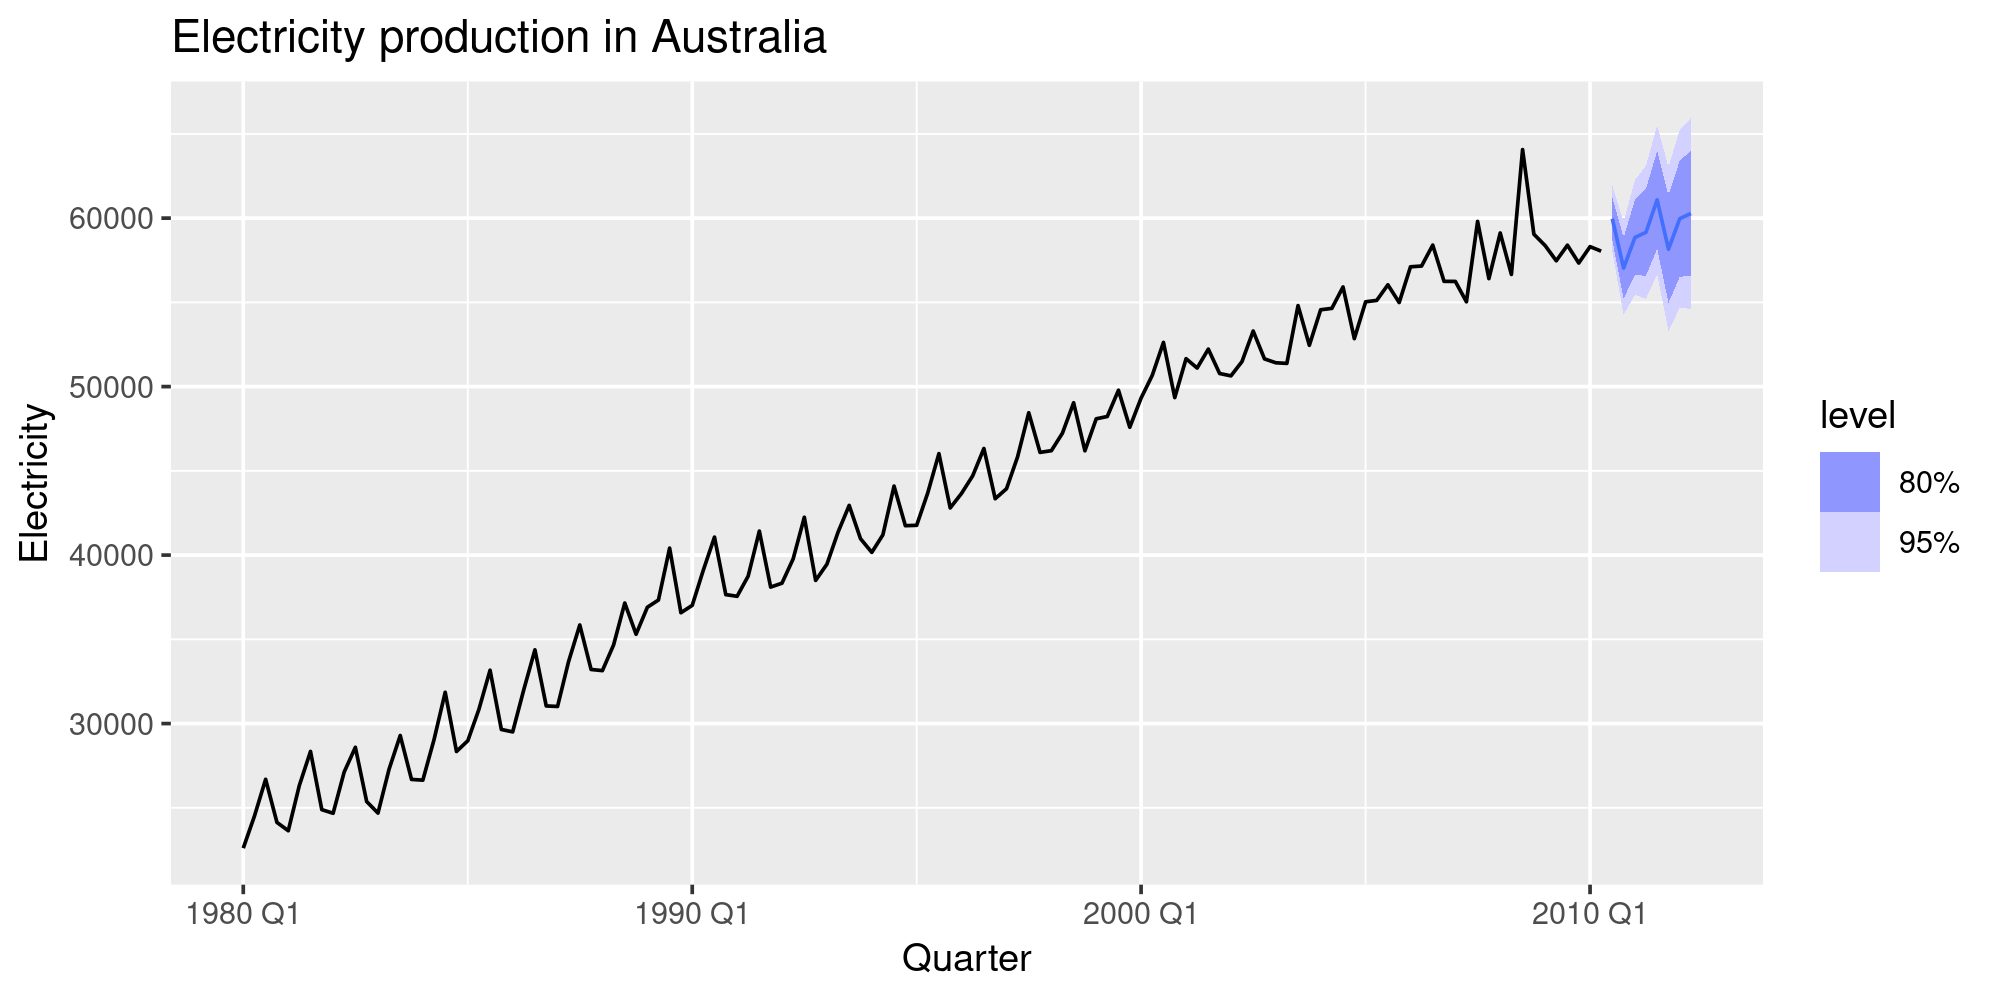

In [5]:
recent_aus_production |>
    model(stlf = decomposition_model(
        STL(Electricity ~ trend(window = 7), robust = TRUE),
        NAIVE(season_adjust~drift()),
        SNAIVE(season_year)
      )) |>
    forecast() |>
    autoplot(dcmp) +
    labs(y = "Electricity", title = "Electricity production in Australia")

What do the residual diagnostics tell us?

Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 4 rows containing non-finite outside the scale range (`stat_bin()`).”


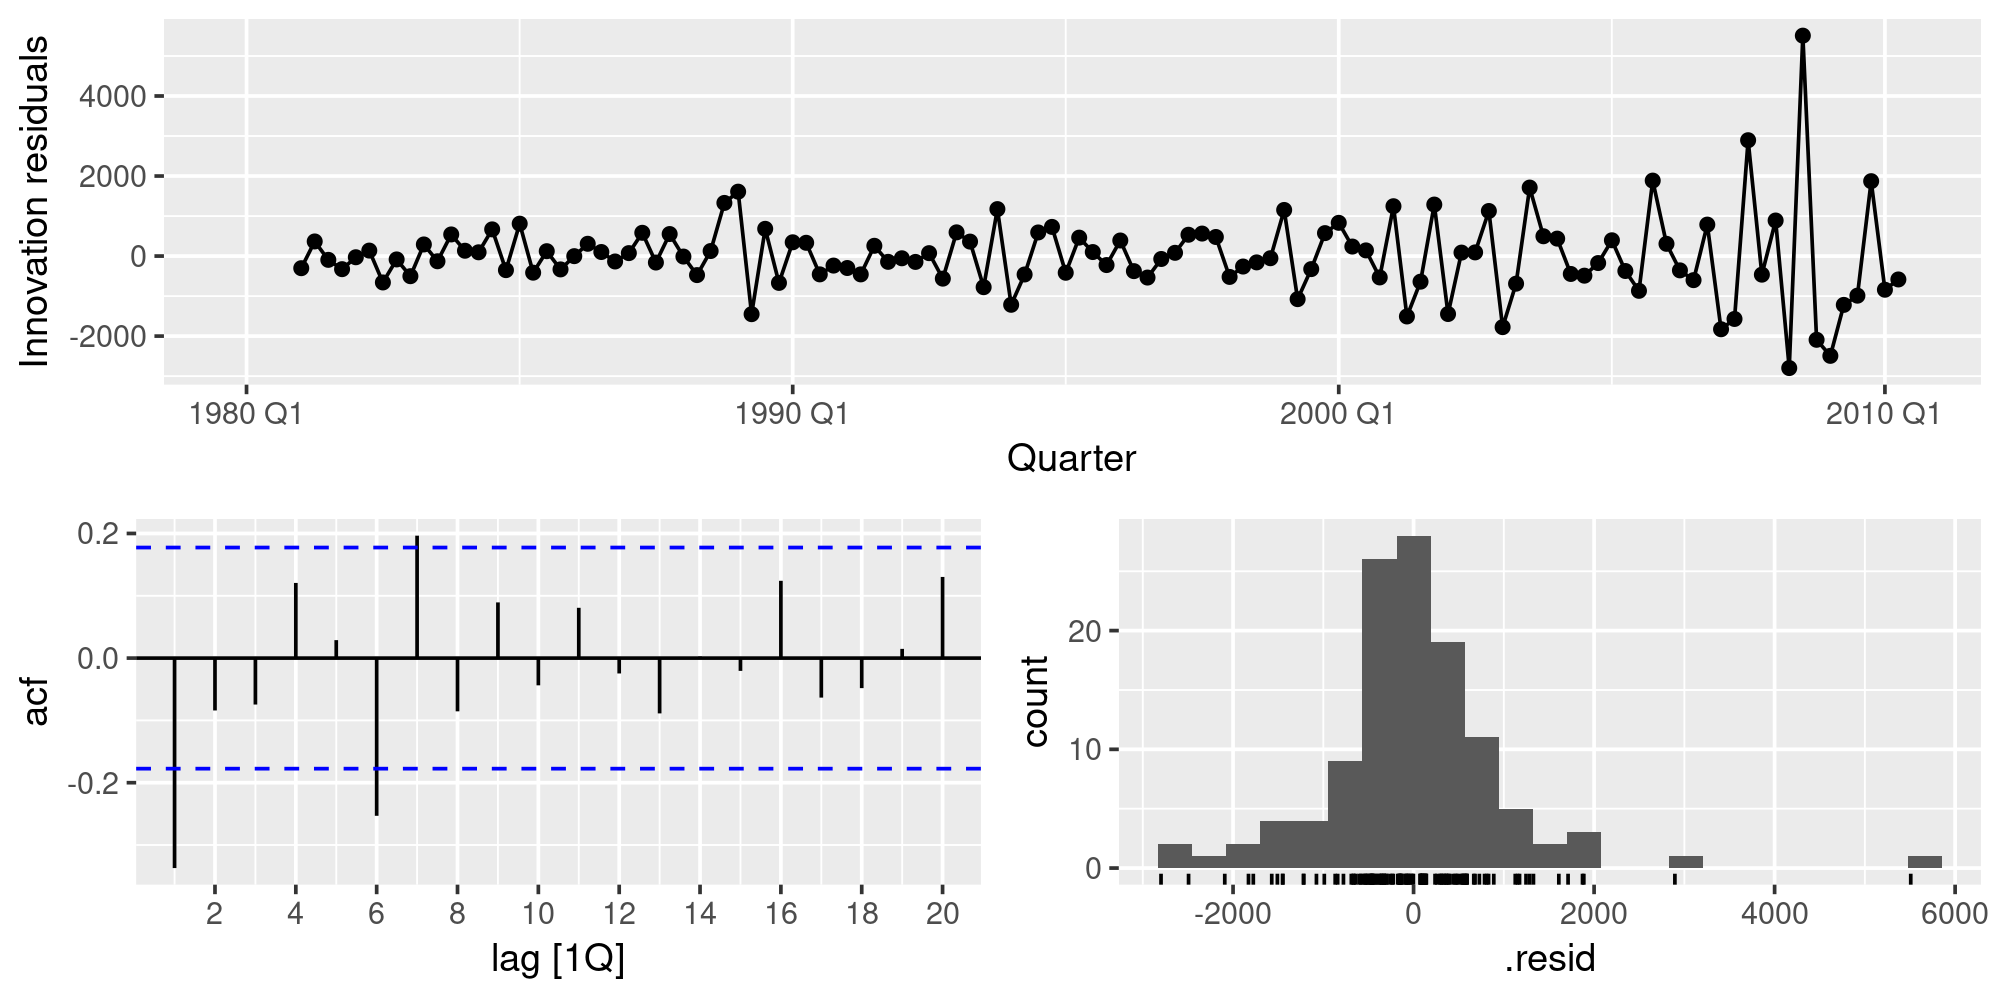

In [6]:
recent_aus_production |>
    model(stlf = decomposition_model(
        STL(Electricity ~ trend(window = 7), robust = TRUE),
        NAIVE(season_adjust~drift()),
        SNAIVE(season_year)
      )) |>
    gg_tsresiduals()

## Evaluating point forecast accuracy

The accuracy of forecasts can only be determined by considering how well a model performs on new data that were not used when fitting the model.


<p align="center">
  <img src="img/traintest-1.png" alt="Training and test data" width="1000"/>
</p>

The size of the test set is typically about 20% of the total sample. However,

- A model which fits the training data well will not necessarily forecast well.
- A perfect fit can always be obtained by using a model with enough parameters.
- Over-fitting a model to data is just as bad as failing to identify a systematic pattern in the data.


## Functions to subset a time series

In [7]:
aus_production_train <- recent_aus_production |>
    filter(year(Quarter) < 2006)

aus_production_test <- recent_aus_production |>
    filter(year(Quarter) >= 2006)

aus_production_test

Quarter,Beer,Tobacco,Bricks,Cement,Electricity,Gas
<qtr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2006 Q1,438,NA,NA,2027,57112,171
2006 Q2,386,NA,NA,2278,57157,224
⋮,⋮,⋮,⋮,⋮,⋮,⋮
2010 Q1,414,NA,NA,1904,58309,205
2010 Q2,374,NA,NA,2401,58041,236


## Forecast errors

A forecast “error” is the difference between an observed value and its forecast.

$$ e_{T+h} = y_{T+h} - \hat{y}_{T+h|T}, $$

where the training data is given by $\{y_1,\dots,y_T\}$ and the test data is given by $\{y_{T+1},y_{T+2},\dots\}$.

Note that forecast errors are different from residuals in two ways. 
- Residuals are calculated on the training set while forecast errors are calculated on the test set. 
- Residuals are based on one-step forecasts while forecast errors can involve multi-step forecasts.

A forecast method that minimises the MAE will lead to forecasts of the median, while minimising the RMSE will lead to forecasts of the mean.

## Scale-dependent errors

The forecast errors are on the same scale as the data.

The two most commonly used scale-dependent measures are based on the absolute errors or squared errors

$$ 
\begin{align*}
  \text{Mean absolute error: MAE} & = \text{mean}(|e_{t}|),\\
  \text{Root mean squared error: RMSE} & = \sqrt{\text{mean}(e_{t}^2)}.
\end{align*}
$$

## Percentage errors

The percentage error is given by $p_{t} = 100 e_{t}/y_{t}$.
The most commonly used measure is:
$$ \text{Mean absolute percentage error: MAPE} = \text{mean}(|p_{t}|).$$

Measures based on percentage errors have the disadvantage of being infinite or undefined if $y_t=0$ for any $t$ in the period of interest, and having extreme values if any $y_t$ is close to zero. 


## Scaled errors (MASE)

Scaled errors are an alternative to using percentage errors when comparing forecast accuracy across series with different units.

For a non-seasonal time series, a useful way to define a scaled error uses naïve forecasts: 

$$ 
q_{j} = \frac{\displaystyle e_{j}}
    {\displaystyle\frac{1}{T-1}\sum_{t=2}^T |y_{t}-y_{t-1}|}.
$$

For seasonal time series, a scaled error can be defined using seasonal naïve forecasts:
$$
q_{j} = \frac{\displaystyle e_{j}}
    {\displaystyle\frac{1}{T-m}\sum_{t=m+1}^T |y_{t}-y_{t-m}|}.
$$
 
The mean absolute scaled error is simply 
 $$\text{MASE} = \text{mean}(|q_{j}|).$$

## Scaled errors (RMSSE)

Scaled errors are an alternative to using percentage errors when comparing forecast accuracy across series with different units.

Similarly, the root mean squared scaled error is given by 
$$ \text{RMSSE} = \sqrt{\text{mean}(q_{j}^2)},$$
where
$$q^2_{j} = \frac{\displaystyle e^2_{j}}
    {\displaystyle\frac{1}{T-m}\sum_{t=m+1}^T (y_{t}-y_{t-m})^2}.$$

## Example (Australian Electricity Production)

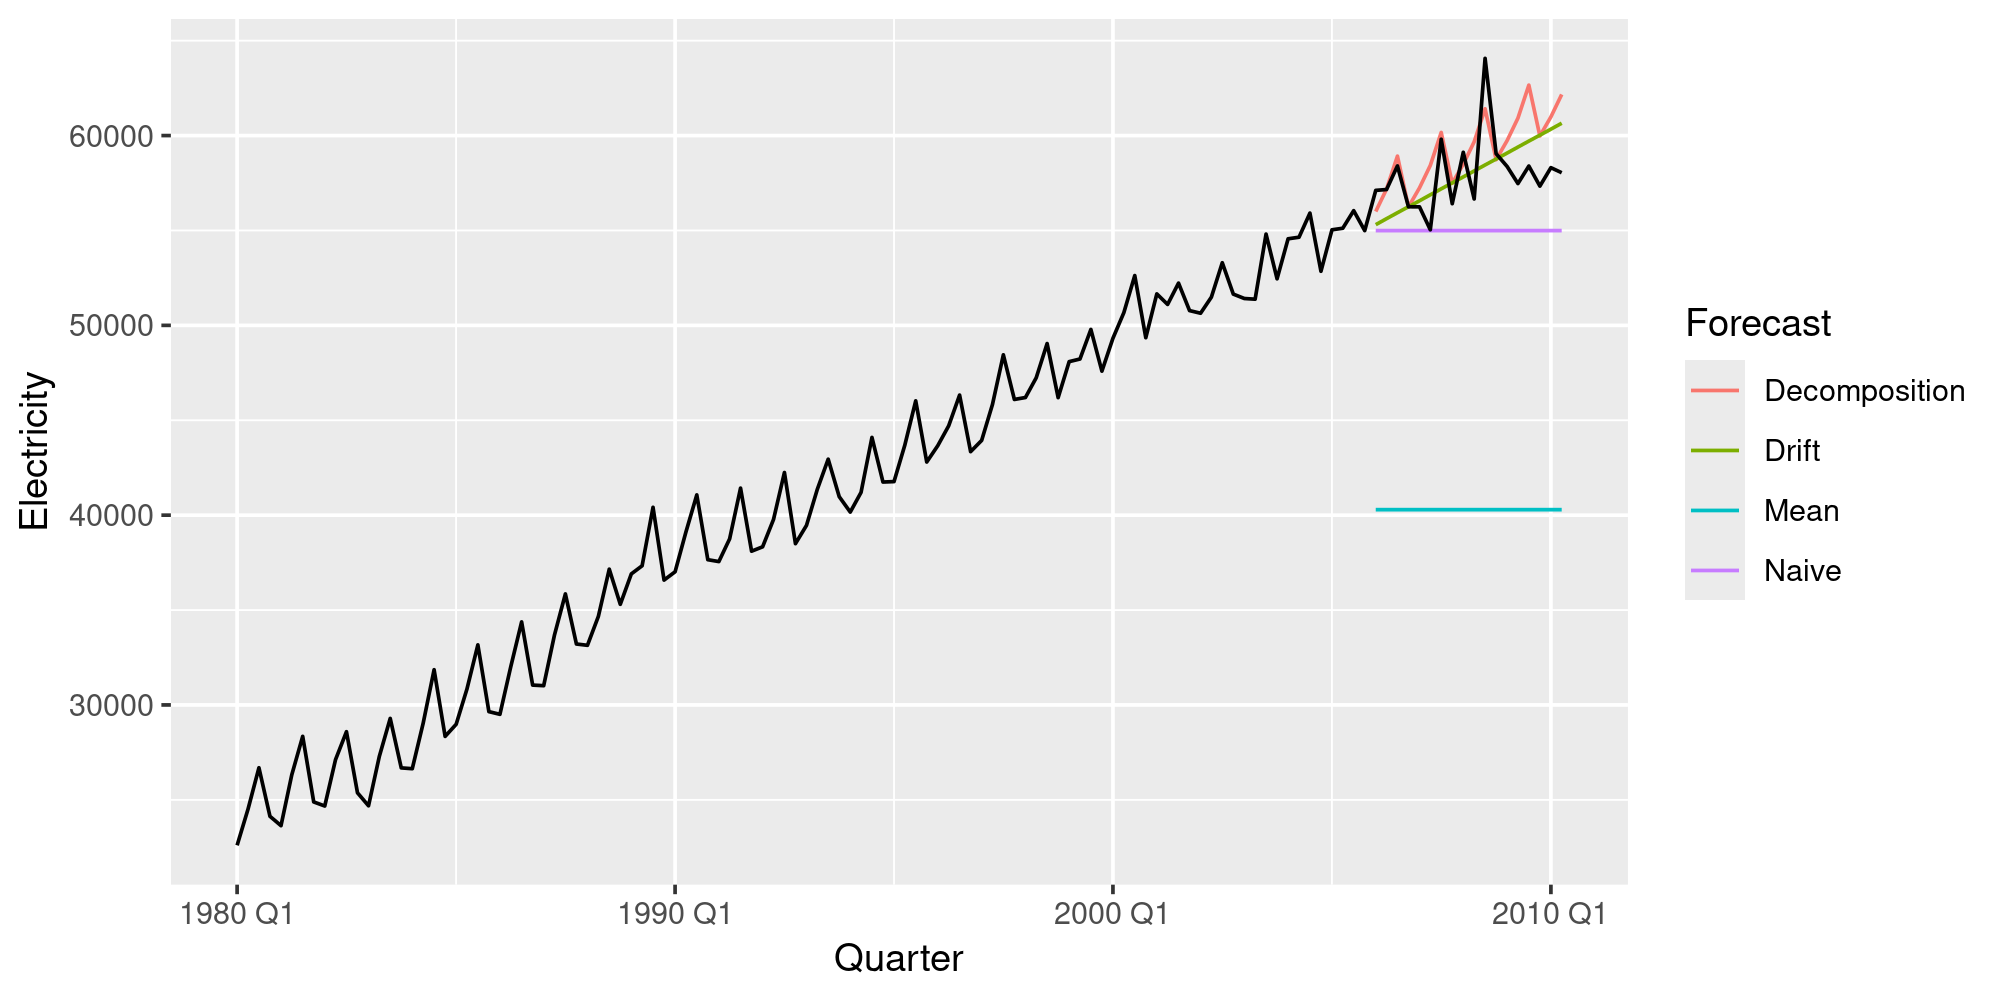

In [8]:
electricity_fc <- aus_production_train |>
    model(Mean = MEAN(Electricity),
          Naive = NAIVE(Electricity),
          Drift = NAIVE(Electricity~drift()),
          Decomposition = decomposition_model(
            STL(Electricity ~ trend(window = 7), robust = TRUE),
            NAIVE(season_adjust~drift()),
            SNAIVE(season_year)
          )) |>
    forecast(h=18)

electricity_fc |> autoplot(recent_aus_production, level = NULL) +
    guides(colour = guide_legend(title = "Forecast"))

In [9]:
electricity_fc |> accuracy(recent_aus_production) |>
    select(.model, .type, MAE, RMSE, MAPE, MASE, RMSSE)

.model,.type,MAE,RMSE,MAPE,MASE,RMSSE
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Decomposition,Test,1812.078,2297.345,3.129807,1.423325,1.515476
Drift,Test,1756.899,2144.598,2.990016,1.379984,1.414714
Mean,Test,17668.581,17769.542,30.415089,13.878065,11.721925
Naive,Test,2964.889,3516.879,5.019257,2.328819,2.319958


## Evaluating distributional forecast accuracy

The preceding measures all measure point forecast accuracy. When evaluating distributional forecasts, we need to use some other measures.

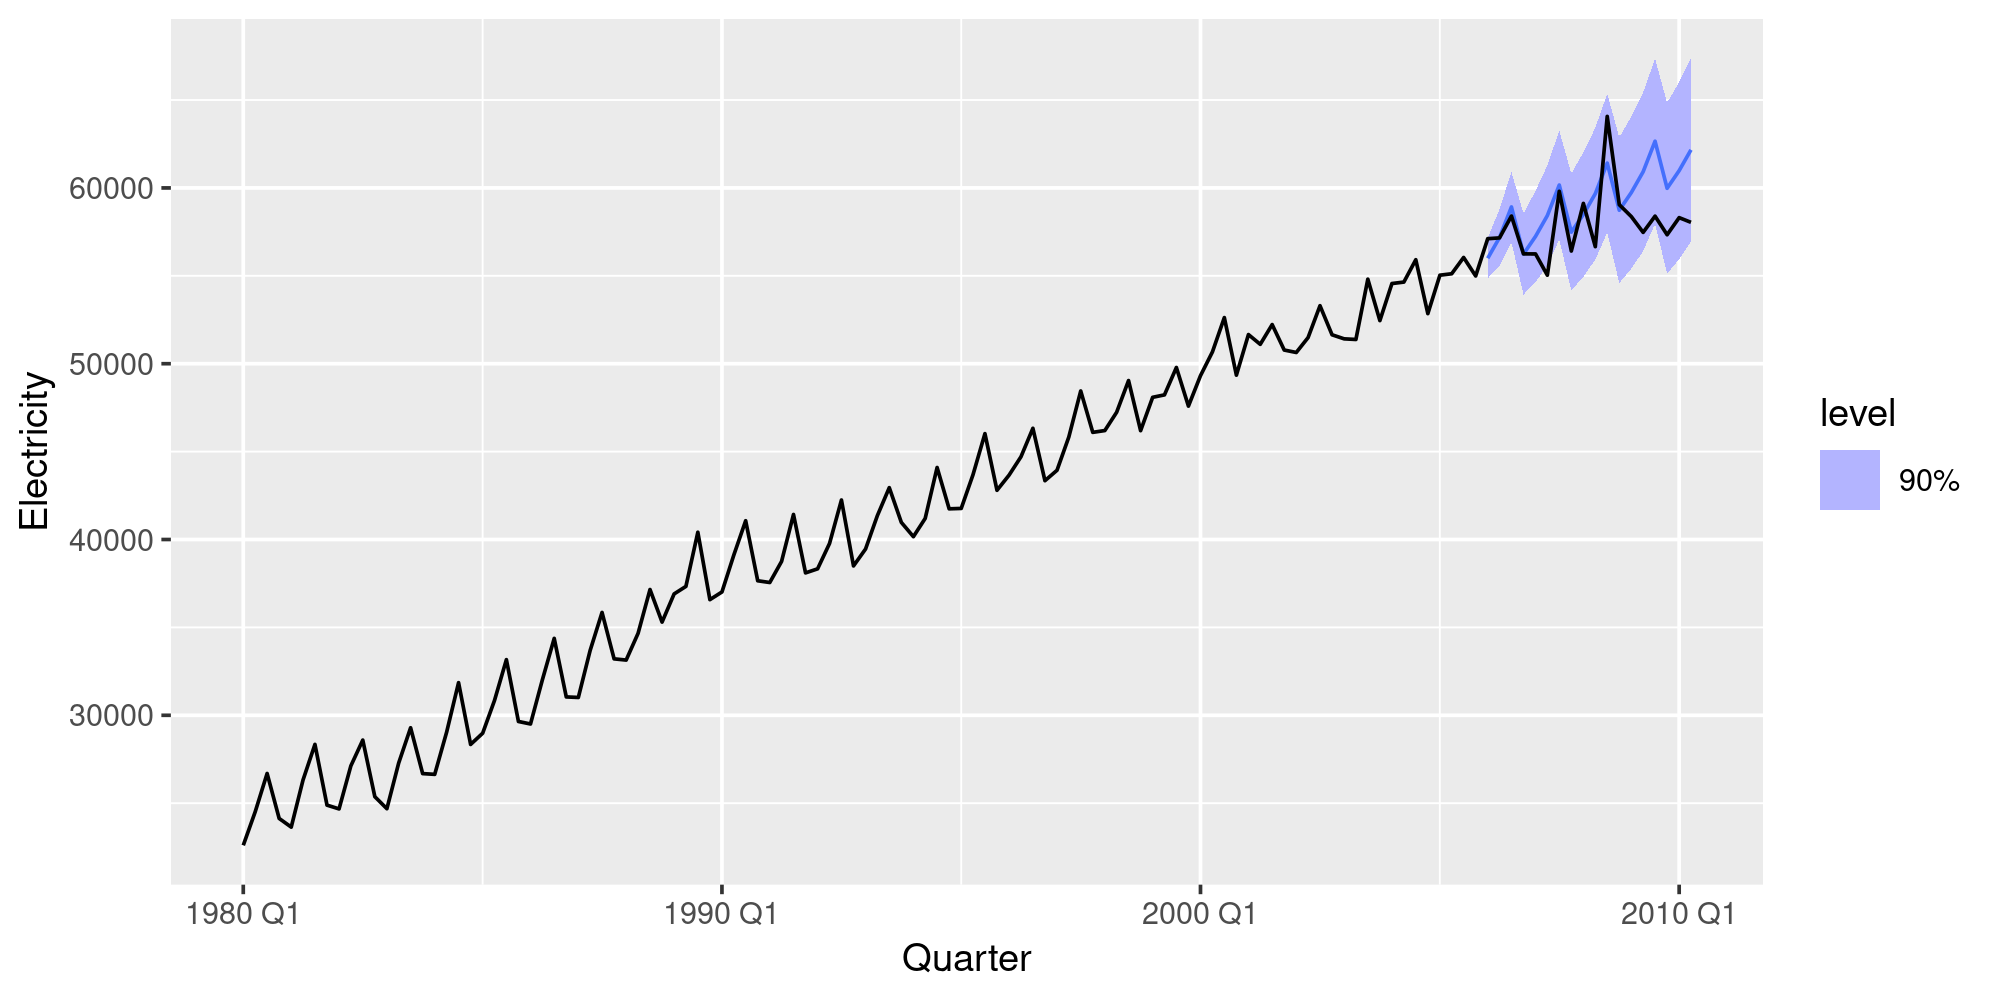

In [10]:
electricity_fc <- aus_production_train |>
    model(Mean = MEAN(Electricity),
          SeasonalNaive = SNAIVE(Electricity),
          Drift = NAIVE(Electricity~drift()),
          Decomposition = decomposition_model(
            STL(Electricity ~ trend(window = 7), robust = TRUE),
            NAIVE(season_adjust~drift()),
            SNAIVE(season_year)
          )) |>
    forecast(h=18)

electricity_fc |> 
    filter(.model=="Decomposition") |>
    autoplot(recent_aus_production, level = 90)

## Winkler Score

If the $100(1−α)\%$ prediction interval at time $t$ is given by $[\ell_{\alpha,t}, u_{\alpha,t}]$, then the Winkler score is defined as the length of the interval plus a penalty if the observation is outside the interval: 
$$
W_{\alpha,t} = \begin{cases}
  (u_{\alpha,t} - \ell_{\alpha,t}) + \frac{2}{\alpha} (\ell_{\alpha,t} - y_t) & \text{if } y_t < \ell_{\alpha,t} \\
  (u_{\alpha,t} - \ell_{\alpha,t})   & \text{if }  \ell_{\alpha,t} \le y_t \le u_{\alpha,t} \\
  (u_{\alpha,t} - \ell_{\alpha,t}) + \frac{2}{\alpha} (y_t - u_{\alpha,t}) & \text{if } y_t > u_{\alpha,t}.
  \end{cases}
  $$
  
 For observations that fall within the interval, the Winkler score is simply the length of the interval. Thus, low scores are associated with narrow intervals. However, if the observation falls outside the interval, the penalty applies, with the penalty proportional to how far the observation is outside the interval.

In [11]:
electricity_fc |>
    accuracy(recent_aus_production, list(winkler = winkler_score), level = 90)

.model,.type,winkler
<chr>,<chr>,<dbl>
Decomposition,Test,7589.226
Drift,Test,20837.548
Mean,Test,68911.868
SeasonalNaive,Test,12430.231


## Scale-free comparisons using skill scores

As with point forecasts, it is useful to be able to compare the distributional forecast accuracy of several methods across series on different scales. For point forecasts, we used scaled errors for that purpose. Another approach is to use skill scores. These can be used for both point forecast accuracy and distributional forecast accuracy.

For example, if we use the naïve method as a benchmark:
$$
\frac{\text{Winkler}_{\text{Naïve}} - \text{Winkler}}{\text{Winkler}_{\text{Naïve}}}.
$$
Of course, the skill score for the benchmark method is 0 because it can’t improve on itself.

The `skill_score()` function can be used with any accuracy measure. 

In [12]:
electricity_fc |>
    accuracy(recent_aus_production, list(winkler = winkler_score, 
                                         skill = skill_score(winkler_score)),
             level = 90)

.model,.type,winkler,skill
<chr>,<chr>,<dbl>,<dbl>
Decomposition,Test,7589.226,0.3894542
Drift,Test,20837.548,-0.6763605
Mean,Test,68911.868,-4.5438930
SeasonalNaive,Test,12430.231,0.0000000


## Guided Workbook

The data set `tourism` contains quarterly visitor nights (in thousands) from 1998 to 2017 for 76 regions of Australia.

In [13]:
tourism

Quarter,Region,State,Purpose,Trips
<qtr>,<chr>,<chr>,<chr>,<dbl>
1998 Q1,Adelaide,South Australia,Business,135.0777
1998 Q2,Adelaide,South Australia,Business,109.9873
⋮,⋮,⋮,⋮,⋮
2017 Q3,Yorke Peninsula,South Australia,Visiting,27.76673
2017 Q4,Yorke Peninsula,South Australia,Visiting,46.28158


### Problem 1a

Extract data from the Gold Coast region using `filter()` and aggregate total overnight trips (sum over Purpose) using `summarise()`. 

Call this new dataset `gc_tourism`.

In [14]:
# TODO: In-class exercise

### Problem 1b

Using `slice()` or `filter()`, create three training sets for this data excluding the last 1, 2 and 3 years.


In [15]:
# TODO: In-class exercise

### Problem 1c

Compute one year of forecasts for each training set using the seasonal naive (`SNAIVE()`) method.

Call these `gc_fc_1`, `gc_fc_2` and `gc_fc_3`, respectively.

In [16]:
# TODO: In-class exercise

### Problem 1d

Use `accuracy()` to compare the test set forecast accuracy using MAPE. Comment on these.

In [17]:
# TODO: In-class exercise

## Time series cross-validation

A more sophisticated version of training/test sets is time series cross-validation. In this procedure, there are a series of test sets, each consisting of a single observation. The corresponding training set consists only of observations that occurred prior to the observation that forms the test set.

<p align="center">
  <img src="img/cv1-1.png" alt="Cross-validation" width="1000"/>
</p>

The forecast accuracy is computed by averaging over the test sets. This procedure is sometimes known as “evaluation on a rolling forecasting origin” because the “origin” at which the forecast is based rolls forward in time.

With time series forecasting, one-step forecasts may not be as relevant as multi-step forecasts. In this case, the cross-validation procedure based on a rolling forecasting origin can be modified to allow multi-step errors to be used. Suppose that we are interested in models that produce good 4-step-ahead forecasts. Then the corresponding diagram is shown below.


<p align="center">
  <img src="img/cv4-1.png" alt="Cross-validation (multi-step)" width="1000"/>
</p>


## Creating the training sets for cross-validation

The `stretch_tsibble()` function is used to create many training sets. 

In this example, we start with a training set of length `.init=12`, and increase the size of successive training sets by `.step=4`.

The `.id` column provides a new key indicating the various training sets. 

In [18]:
recent_aus_production |>
    select(Quarter, Electricity) |>
    stretch_tsibble(.init = 12, .step = 4)

Quarter,Electricity,.id
<qtr>,<dbl>,<int>
1980 Q1,22604,1
1980 Q2,24510,1
⋮,⋮,⋮
2009 Q3,58394,28
2009 Q4,57336,28


## Model evaluation via Cross-validation

A good way to choose the best forecasting model is to find the model with the smallest RMSE computed using time series cross-validation.

In [19]:
recent_aus_production |>
    select(Quarter, Electricity) |>
    stretch_tsibble(.init = 12, .step = 4) |>
    model(Mean = MEAN(Electricity),
          SeasonalNaive = SNAIVE(Electricity),
          Drift = NAIVE(Electricity~drift()),
          Decomposition = decomposition_model(
            STL(Electricity ~ trend(window = 7), robust = TRUE),
            NAIVE(season_adjust~drift()),
            SNAIVE(season_year)
          )) |>
    forecast(h=4) |>
    accuracy(recent_aus_production) |>
    select(.model, .type, MAE, RMSE, MAPE, MASE, RMSSE) |>
    arrange(.model)

Warning message:
“The future dataset is incomplete, incomplete out-of-sample data will be treated as missing. 
2 observations are missing between 2010 Q3 and 2010 Q4”


.model,.type,MAE,RMSE,MAPE,MASE,RMSSE
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Decomposition,Test,849.7941,1191.071,1.810618,0.6163434,0.7115996
Drift,Test,1489.6754,1923.836,3.410401,1.0804401,1.1493869
Mean,Test,10718.7301,11695.843,22.643853,7.7741404,6.9876264
SeasonalNaive,Test,1388.5818,1693.955,3.216795,1.0071184,1.0120457


## Next Time

- Time series Regression Models